# loading modules

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import scVI
from benchmarking import *
from helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# parameters

In [3]:
learning_rate = 0.0004
epsilon = 0.01

# import data

In [5]:
# expression data
data_path = "/home/ubuntu/single-cell-scVI/data/Zeisel/"
expression_train = np.loadtxt(data_path + "data_train")
expression_test = np.loadtxt(data_path + "data_test")

# zero masked matrix
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")
#labels
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")

In [6]:
expression_train.shape

(2253, 558)

In [7]:
def agg_clusters_2(c):
    new_c = np.zeros_like(c)
    for t in np.arange(c.shape[0]):
        if c[t] in [2, 6, 5]:
            new_c[t] = 0
        else:
            new_c[t] = 1
    return new_c

def agg_clusters_3(c):
    new_c = np.zeros_like(c)
    for t in np.arange(c.shape[0]):
        if c[t] in [2, 6, 5]:
            new_c[t] = 0
        elif c[t] in [1, 3]: 
            new_c[t] = 1
        else:
            new_c[t] = 2
    return new_c

def agg_clusters_4(c):
    new_c = np.zeros_like(c)
    for t in np.arange(c.shape[0]):
        if c[t] in [2, 6, 5]:
            new_c[t] = 0
        elif c[t] in [1, 3]: 
            new_c[t] = 1
        elif c[t] in [0]:
            new_c[t] = 2
        else:
            new_c[t] = 3
    return new_c

# Computational graph

In [8]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

# getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# loading data
model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var)

#starting computing session
sess = tf.Session()

Running scVI on 558 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [9]:
# start a new graph and fit the training set
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 250)

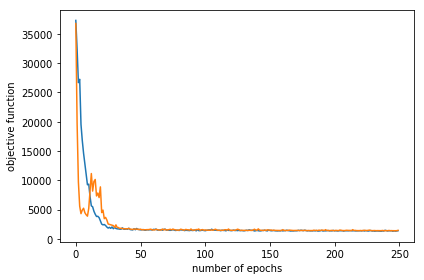

In [42]:
plot_training_info(result)

In [54]:
dic_full = {expression: expression_train, training_phase:False}
latent = sess.run(model.z, feed_dict=dic_full)
cluster_scores(latent, 7, c_train)

[0.28131631, 0.78855979292393874, 0.81132417587061612]

In [56]:
print cluster_scores(latent, 2, agg_clusters_2(c_train))
print cluster_scores(latent, 3, agg_clusters_3(c_train))
print cluster_scores(latent, 4, agg_clusters_4(c_train))
print cluster_scores(latent, 7, c_train)

[0.32763597, 0.76727788550279996, 0.85143768403508435]
[0.2937676, 0.69296827058660737, 0.77395790102006323]
[0.32925251, 0.6949642749813848, 0.6757547322038292]
[0.28131631, 0.78855979292393907, 0.81132417587061612]


# Evaluation methods

### likelihood

In [40]:
res = train_model(model, (expression_test, expression_test), sess, 1000, step=model.test_step)
eval_likelihood(model, expression_test, sess)

KeyboardInterrupt: 

##### Vizualisation

In [ ]:
latent = eval_latent(model, expression_train, sess)
show_tSNE(latent, c_train)

### analyse the posterior

In [8]:
#prepare the original values 
all_index = i[ix], j[ix]
y = expression_train[all_index]
y = y[X_zero[all_index] == 0]
ymax = 10
mask = y < ymax
y = y[mask]
l = y.shape[0]

x = np.zeros((l, 100))

# Now look at how the posterior covers the imputed values
for t in range(100):
    dic_full = {expression: expression_train, training_phase:False, kl_scalar:1.} 
    rate, dropout = sess.run((model.px_rate, model.px_dropout), feed_dict=dic_full)
    dispersion = np.tile(sess.run((tf.exp(model.px_r))[0]), (rate.shape[0], 1))
    p = rate / (rate + dispersion)
    r = dispersion 
    dropout = 1. / (1. + np.exp(-dropout))
    l_train = np.random.gamma(r, p / (1-p))
    X = np.random.poisson(l_train)
    
    x_ = X[all_index] 
    x_ = x_[X_zero[all_index] == 0]
    x[:, t] = x_[mask]
    
mask = np.mean(x, axis=1) < ymax
x = x[mask]
y = y[mask]

l = np.minimum(x.shape[0], y.shape[0])

x = x[:l]
y = y[:l]

index = np.random.choice(l, size=100000)
x_ = x[index]
y_ = y[index]



In [49]:
def posterior_data_scVI(latent, hrange=(0, 10), posterior_sample=50, all_genes=True):
    #prepare the original values 
    
    if all_genes:
        all_index = i[ix], j[ix]
        y = expression_train[all_index]
        y = y[X_zero[all_index] == 0]
    else:
        y = expression_train[:, 253].flatten()
        

    (ymin, ymax) = hrange
    mask = y < ymax
    y = y[mask]
    l = y.shape[0]

    x = np.zeros((l, posterior_sample))

    # Now look at how the posterior covers the imputed values
    for t in range(posterior_sample):
        dic_full = {expression: expression_train, training_phase:False, kl_scalar:1.} 
        rate, dropout = sess.run((model.px_rate, model.px_dropout), feed_dict=dic_full)
        dispersion = np.tile(sess.run((tf.exp(model.px_r))[0]), (rate.shape[0], 1))
        p = rate / (rate + dispersion)
        r = dispersion 
        dropout = 1. / (1. + np.exp(-dropout))
        l_train = np.random.gamma(r, p / (1-p))
        X = np.random.poisson(l_train)
        generate = X

        if all_genes:
            x_ = generate[all_index] 
            x_ = x_[X_zero[all_index] == 0]
        else:
            x_ = generate[:, 253].flatten()
            
            
        x[:, t] = x_[mask]

    if not all_genes:
        mask = np.mean(x, axis=1) < ymax
        x = x[mask]
        y = y[mask]

#     l = np.minimum(x.shape[0], y.shape[0])

#     x = x[:l]
#     y = y[:l]

    #index = np.random.choice(l, size=100000)
    #x_ = x[index]
    #y_ = y[index]
    
    x_ = x
    y_ = y
    
    return x_, y_

In [16]:
from scipy.stats import kde
def draw_custom_hist_data(x, y):
    
    # First digitize the original values
    # makes a K x K matrix
    K = 15
    hist, count_bins = np.histogram(mapping(y), bins=K)
    y_bin_assign = np.digitize(mapping(y), count_bins)
    
    # now we get for each value and for each eventual posterior the histogram assignment
    x_bin_assign = np.digitize(mapping(x), count_bins)
    
    #print np.unique(y_bin_assign)
    # Let us construct the full matrix to visualize
    
    mat = np.zeros(shape=(K, K))
    for k in range(1, K+1):
        assign_slice = x_bin_assign[y_bin_assign == k].flatten()
        assign_slice = assign_slice[assign_slice > 0]
        assign_slice = assign_slice[assign_slice < K+1]
        for i in range(1, K+1):
            assign_slice = np.append(assign_slice, i)
        #print np.unique(assign_slice)
        _, mat[k-1] = np.unique(assign_slice, return_counts=True)
        
    #print mat
    mat = mat / np.sum(mat, axis=0)
    plt.xticks(np.arange(mat.shape[0])[::2], inv_mapping(count_bins).astype(np.int)[::2])
    plt.yticks(np.arange(mat.shape[0])[::2], inv_mapping(count_bins).astype(np.int)[::2])
    plt.imshow(mat.T, origin='lower', interpolation="none")

In [18]:
def draw_box_data(x, y, nbins=10):
    def moving_average(a, n=3) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    hist, bins = np.histogram(np.log(1 + y), bins=nbins)
    bin_assign = np.digitize(np.log(1 + x), bins, right=False)
    data = [x[bin_assign == t].flatten() for t in np.unique(bin_assign) if (t > 0 and t <= nbins) ]
    return np.exp(moving_average(bins, n=2)) -1, data

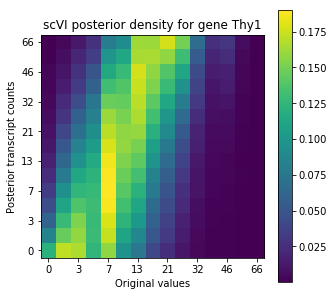

In [17]:
latent = eval_latent(model, expression_train, sess)
x__, y__ = posterior_data_scVI(latent, hrange=(0, 500), posterior_sample=500, all_genes=False)

mapping = lambda x: np.log(1 + x / 10.)
inv_mapping = lambda x: (np.exp(x) - 1) * 10

plt.figure(figsize=(5, 5))
draw_custom_hist_data(x__, y__)
plt.title("scVI posterior density for gene Thy1")
plt.xlabel("Original values")
plt.ylabel("Posterior transcript counts")
plt.colorbar()
plt.savefig("scVI_posterior_Thy1.pdf", dpi=300)

In [45]:
all_index = i[ix], j[ix]
np.sum(X_zero[all_index] == 0) / float(np.shape(X_zero.flatten())[0])

0.07087085797192752

In [50]:
x__, y__ = posterior_data_scVI(latent, hrange=(0, 10), posterior_sample=50)

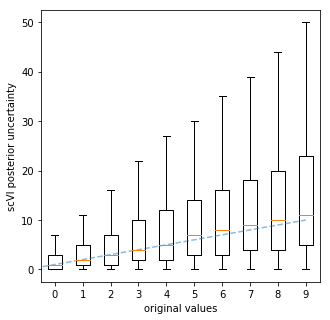

In [52]:
data = [x__[y__ == t].flatten() for t in range(0, 10)]
plt.figure(figsize=(5, 5))
plt.boxplot(data, sym="")
plt.xticks(range(1, 11), range(0, 10))


l = np.linspace(0, 10, 50)
plt.plot(l, l, linestyle="--", alpha=0.5)
plt.xlabel("original values")
plt.ylabel("scVI posterior uncertainty")
plt.savefig("scVI_posterior.pdf", dpi=300)

### imputation

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

In [18]:
def plot_imputation(imputed, original, zeros, i, j, ix, xtext):
    all_index = i[ix], j[ix]
    x, y = imputed[all_index], original[all_index]

    x = x[zeros[all_index] == 0]
    y = y[zeros[all_index] == 0]
    
    ymax = 10
    mask = x < ymax
    x = x[mask]
    y = y[mask]

    mask = y < ymax
    x = x[mask]
    y = y[mask]

    l = np.minimum(x.shape[0], y.shape[0])

    x = x[:l]
    y = y[:l]

    data = np.vstack([x, y])
    
    print data.shape
    
    plt.figure(figsize=(5, 5))

    axes = plt.gca()
    axes.set_xlim([0,ymax])
    axes.set_ylim([0,ymax])
    
    nbins=50

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = kde.gaussian_kde(data)
    xi, yi = np.mgrid[0:ymax:nbins*1j, 0:ymax:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    plt.title(xtext, fontsize=12)
    plt.ylabel("Imputed counts")
    plt.xlabel('Original counts')
    
    plt.pcolormesh(yi, xi, zi.reshape(xi.shape), cmap="Reds")
    
    a, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)
    l = np.linspace(0, ymax)
    plt.plot(l, a * l, color='black')
    
    plt.plot(l, l, color='black', linestyle=":")

In [23]:
# start a new fresh model on a corrupted training set
sess.run(tf.global_variables_initializer())
res = train_model(model, (X_zero, expression_test), sess, 200)
eval_imputed_data(model, (X_zero, i, j, ix), expression_train, sess)

2.4522085189819336

In [24]:
dic_zero = {expression: X_zero, training_phase:False, kl_scalar:1.} 
rate_  = sess.run((model.px_rate), \
                                       feed_dict=dic_zero)

(2, 24677)


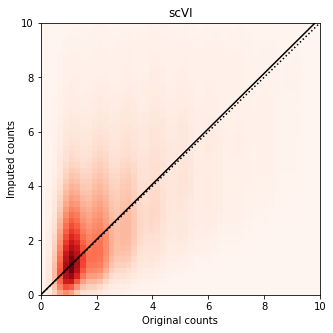

In [25]:
plot_imputation(rate_, expression_train, X_zero, i, j, ix, "scVI")
plt.savefig("scVI_imputation.pdf", dpi=300)

# Distance matrix

In [12]:
latent = eval_latent(model, expression_train, sess)

In [15]:
celltypes = np.array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
       'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
      dtype='|S64')
beloved_order = np.array(['interneurons', 'pyramidal SS', 'pyramidal CA1', 'endothelial-mural', \
 'microglia', 'astrocytes_ependymal', 'oligodendrocytes'])
from matplotlib import gridspec

mapping = [np.where(beloved_order == x)[0][0] for x in celltypes]

def visualize_distance(latent, labels, mapping):
    sorting_labels = [mapping[int(x)] for x in c_train]
    order_latent = np.vstack([x for _, x in sorted(zip(sorting_labels, latent), key=lambda pair: pair[0])])
    order_label = np.vstack([x for _, x in sorted(zip(sorting_labels, labels), key=lambda pair: pair[0])])
    #print order_label
    #lab = 
    distance = scipy.spatial.distance_matrix(order_latent, order_latent)  
    
    fig = plt.figure(figsize=(5, 5)) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 70], height_ratios=[1, 70])
    gs.update(wspace=0.05, hspace=0.05)
    ax0 = plt.subplot(gs[1])
    ax0.imshow(order_label.T, cmap='tab10', interpolation='none', aspect=100)
    ax0.axis('off')
    ax1 = plt.subplot(gs[3], sharex=ax0)
    dis= ax1.imshow(distance, cmap='hot', interpolation='none')
    fig.colorbar(dis, ax=ax1)
    ax1.axis('off')
    ax2 = plt.subplot(gs[2], sharey=ax1)
    ax2.imshow(order_label, cmap='tab10', interpolation='none', aspect=1/100.)
    ax2.axis('off')
    #plt.tight_layout()

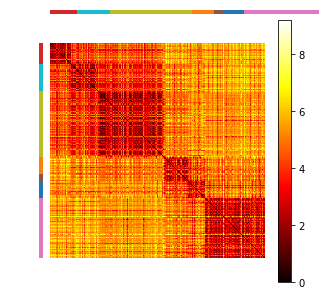

In [16]:
visualize_distance(latent, c_train, mapping)
plt.savefig("scVI_distance.pdf", dpi=300)

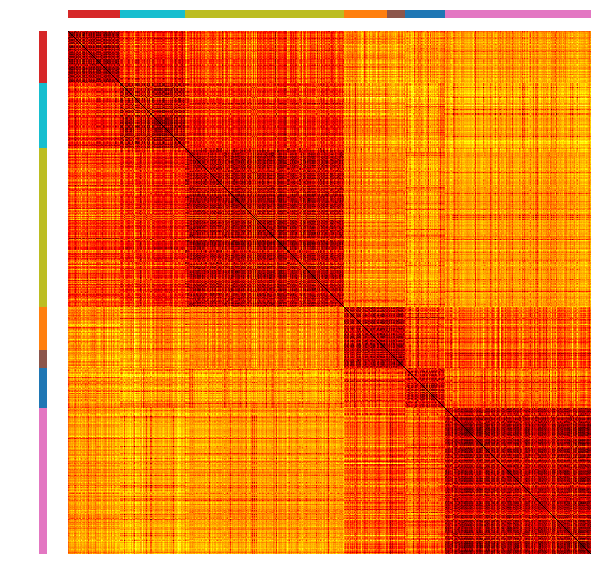

In [25]:
visualize_distance(latent, c_train, mapping)
plt.savefig("scVI_distance.pdf", dpi=300)